#**Đồ án cuối kỳ Nhập môn khoa học dữ liệu**


**Đề tài : Dự báo lượng gạo tiêu thụ trong một năm.**






**Thông tin nhóm:**
<br>
Trần Hữu Chí Bảo - 18120288.
<br>
Trần Thanh Tùng - 18120258.

**Lý do chọn đề tài:**

- Trong bối cảnh biến đổi khí hậu, diện tích trồng trọt bị thu hẹp đáng kể do các nguyên nhân như là: xâm nhập mặn, sạt lở đất, đất đai bạc màu... Dân số biến động liên tục do dịch bệnh, người di cư từ khu vực này sang khu vực khác. Cộng thêm việc các hợp đồng xuất, nhập khẩu gạo thường được ký kết trước vài năm.
<br>
-  Các lý do này dẫn đến ý tưởng cần dự đoán trước lượng gạo tiêu thụ của một nước để có thể bảo đảm an ninh lương thực quốc gia và tối ưu hóa cán cân xuất nhập khẩu.

# I. Thu thập dữ liệu

**Các nguồn dữ liệu:**
<br>
1. http://ricepedia.org là một bách khoa toàn thư trực tuyến nhằm cung cấp tất cả các thông tin cần thiết về lúa gạo, sản xuất lúa gạo và tác động của nó đối với thế giới.
2. https://countryeconomy.com là một website tổng hợp dữ liệu về nền kinh tế của các quốc gia trên thế giới.
3.http://api.worldbank.org/ là một api cho phép request để lấy thông tin thế giới(quốc gia, châu lục,...)

In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

### 1. Parse webstie  http://ricepedia.org

Do dữ liệu trên website đã được trình bày khá cụ thể dưới dạng bảng, nên ta chỉ cần parse bảng này để lấy dữ liệu.
<br>
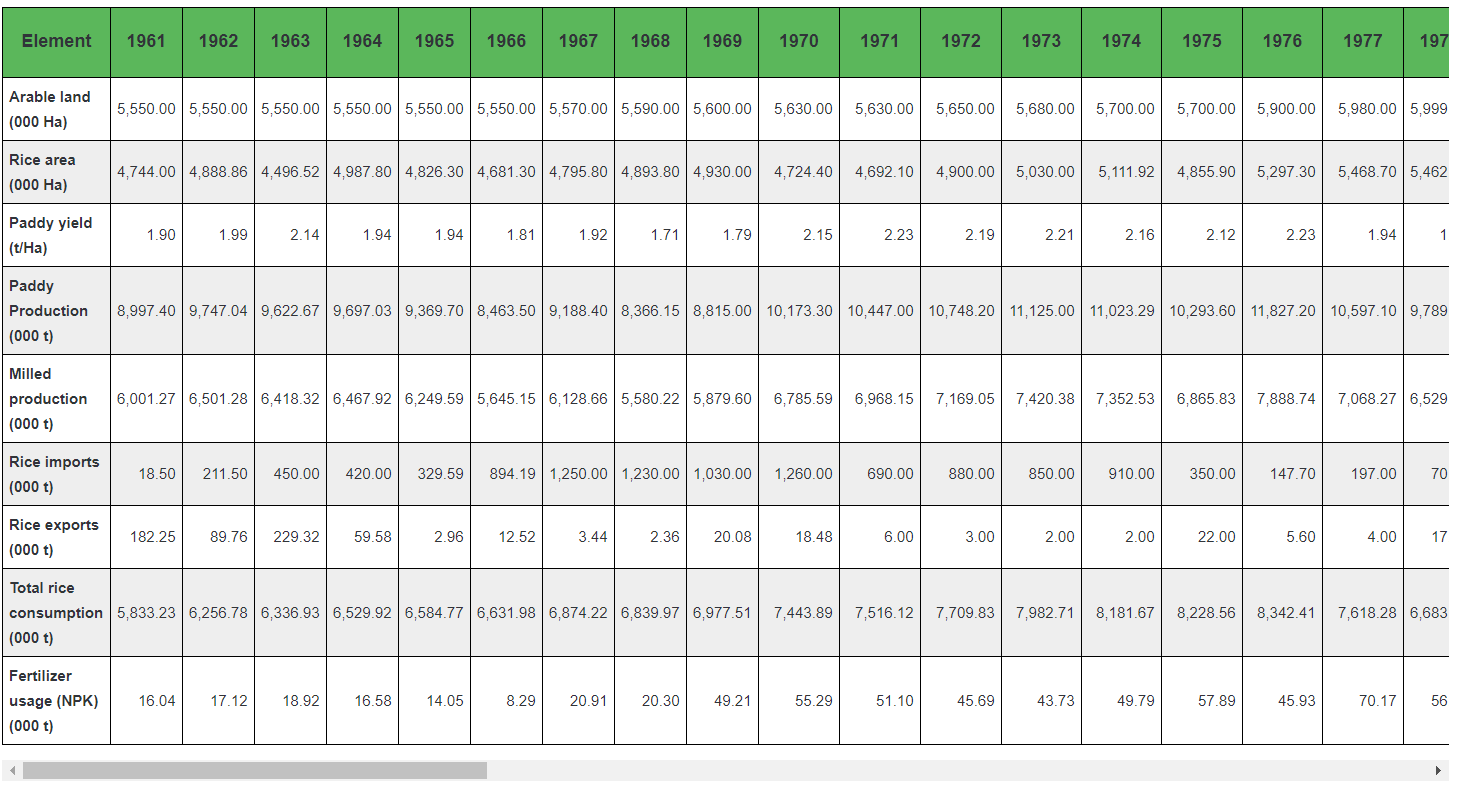

**TIến hành parse bảng**

Đầu tiên ta vào một trang thông tin của một quốc gia bất kỳ để parse
lấy số năm dữ liệu.

In [2]:
url = 'http://ricepedia.org/vietnam'
html_text = requests.get(url).text # Lấy nội dung html của trang chứa các kết quả tuyển dụng 
tree = BeautifulSoup(html_text, 'html.parser') # Parse html
title1 = tree.find_all('td', {'class': 'simple'})
list = []
for key in title1:
    list.append(key.text)
num_years = []
for i in range(10,len(list)):
    num_years.append(list[i])

TIến hành lấy tên các thuộc tính của bảng được lưu trong 2 mảng list1 và list 2

In [3]:
element1 = tree.find_all('th', {'class': 'simple_even'})
element2 = tree.find_all('th', {'class': 'simple_odd'})
def list_all_attribute(element):
    list_attribute = []
    for key1 in element:
        chuoi = key1.text
        x = chuoi.find('(') -1
        list_attribute.append(chuoi[: x])
    return list_attribute
list1 = list_all_attribute(element1)
list2 = list_all_attribute(element2)

Hàm `value_each_element`sẽ tạo ra dictionary chứa key là thuộc tính, value sẽ chứa giá trị của từng thuộc tính trong rice_media.org của 1 quốc gia.

In [4]:
string_class = {'class': 'simple_even'}, {'class': 'simple_odd'}
def value_each_element(list_element, tree,string_class, vitri):
    element_value = tree.find_all('td', string_class[vitri])
    temp2 = []
    temp3 = []
    count = 0
    dem = 0
    for key in element_value:
        temp2.append(key.text)
        count += 1
        if count == len(list):
            temp = []
            for index in range(10, len(temp2)):
                temp.append(temp2[index])
            temp3.append((list_element[dem],temp))
            temp2 = []
            count = 0
            dem += 1
    temp3 = dict(temp3)
    return temp3

Hàm lấy tên các nước trồng lúa ở châu Á và Mỹ latinh.
<br>
Một số quốc gia bị loại bỏ vì không có dữ liệu của từng năm hoặc thiếu hoàn toàn dữ liệu của một thuộc tính.
- biến countries_official: chứa tên tất cả các quốc gia châu á và mỹ la tinh (đảm bảo đúng thứ tự tên quốc gia) để thu thập dữ liệu trên 2 trang còn lại.

In [5]:
def name_countries(url, remove_countries):
    html_text = requests.get(url).text # Lấy nội dung html của trang chứa các kết quả tuyển dụng 
    tree = BeautifulSoup(html_text, 'html.parser') # Parse html
    title1_coutries = tree.find_all('div', {'class':'rt-grid-3'})
    countries = []
    for i in title1_coutries[-1].find_all('a'):
        countries.append(i.text)
    countries_official = [element for element in countries if element not in remove_countries]
    return countries_official
remove_countries = ['China','Philippines', 'Timor-Leste', 'Korea DPR','Korea, Republic of','Dominican Republic','Guyana','Haiti','Nicaragua','Suriname']
url_asia = 'http://ricepedia.org/rice-around-the-world/asia'
countries_official = name_countries(url_asia,remove_countries)
url_america = 'http://ricepedia.org/rice-around-the-world/latin-america-and-the-caribbean'
countries_official += name_countries(url_america,remove_countries)

 Hàm `get_link_url` dùng để lấy link các quốc gia để parse lấy số liệu.
 <br>
  Hàm này sẽ loại bỏ một số quốc gia với lý do như trên.

In [6]:
def get_link_url(url):
    html_text = requests.get(url).text # Lấy nội dung html của trang chứa các kết quả tuyển dụng 
    tree = BeautifulSoup(html_text, 'html.parser') # Parse html
    title1_coutries = tree.find_all('div', {'class':'rt-grid-3'})
    link_url = []
    href_link = title1_coutries[-1].find_all(href = True)
    countries = title1_coutries[-1].find_all('a')
    for a,b in zip(countries,href_link):
        if a.text not in remove_countries:
            link_url.append('http://ricepedia.org' + b['href'])
    return link_url
link_url_countries = get_link_url(url_asia)
link_url_countries += get_link_url(url_america)

In [7]:
link_url_countries

['http://ricepedia.org/index.php/india',
 'http://ricepedia.org/index.php/indonesia',
 'http://ricepedia.org/index.php/bangladesh',
 'http://ricepedia.org/index.php/vietnam',
 'http://ricepedia.org/index.php/myanmar',
 'http://ricepedia.org/index.php/thailand',
 'http://ricepedia.org/index.php/japan',
 'http://ricepedia.org/index.php/cambodia',
 'http://ricepedia.org/index.php/afghanistan',
 'http://ricepedia.org/index.php/bhutan',
 'http://ricepedia.org/index.php/iran',
 'http://ricepedia.org/index.php/iraq',
 'http://ricepedia.org/index.php/kazakhstan',
 'http://ricepedia.org/index.php/lao-people-s-democratic-republic',
 'http://ricepedia.org/index.php/malaysia',
 'http://ricepedia.org/index.php/nepal',
 'http://ricepedia.org/index.php/pakistan',
 'http://ricepedia.org/index.php/sri-lanka',
 'http://ricepedia.org/index.php/turkmenistan',
 'http://ricepedia.org/index.php/uzbekistan',
 'http://ricepedia.org/index.php/argentina',
 'http://ricepedia.org/index.php/brazil',
 'http://ricepe

Hàm `merge_attribute_country` dùng để parse lấy dữ liệu từng nước trong danh sách.

In [8]:
def merge_attribute_country(link_url, list_index,string_class,index):
    many_list_dictionary = []
    for i in range(len(link_url)):
        html_text = requests.get(link_url[i]).text
        tree = BeautifulSoup(html_text, 'html.parser')
        list1_dictionary = value_each_element(list_index, tree, string_class, index)
        many_list_dictionary.append(list1_dictionary)
    return many_list_dictionary

Biến many_list1_dictionary: Lấy dữ liệu 5 thuộc tính đầu của bảng và lưu nó vào 1 list.

In [9]:
many_list1_dictionary = merge_attribute_country(link_url_countries,list1,string_class, 0)

Biến many_list2_dictionary: Lấy dữ liệu 4 thuộc tính sau của bảng và lưu nó vào 1 list.



In [10]:
many_list2_dictionary = merge_attribute_country(link_url_countries,list2,string_class, 1)

Hàm `merge_value_atrribute` tạo ra dictionary trong đó key là merge nhiều thuộc tính giống nhau lại, value sẽ chứa tất cả giá trị của mỗi quốc gia tương ứng với key đang xét.

In [11]:
def merge_value_atrribute(many_list_dictionary):
    merge_list_dictionary = []
    for attribute in many_list_dictionary[0].keys():
        value = []
        for index in range(len(many_list_dictionary)):
            value += many_list_dictionary[index][attribute]
        merge_list_dictionary.append((attribute,value))
    return dict(merge_list_dictionary)

Biến list1_dictionary: tạo ra dictionary từ việc gọi hàm `merge_value_atrribute` của 5 thuộc tính đầu.

In [12]:
list1_dictionary = merge_value_atrribute(many_list1_dictionary)

Biến list2_dictionary: tạo ra dictionary từ việc gọi hàm `merge_value_atrribute` của 4 thuộc tính sau.

In [13]:
list2_dictionary = merge_value_atrribute(many_list2_dictionary)

### 2. Parse website  https://countryeconomy.com

Ta tiến hành lấy dữ liệu GDP bình quân đầu người của quốc gia trong trang này.
<br>
Nguyên nhân bởi vì hầu hết các quốc gia đều có nền kinh tế thị trường. Lương thực hay các sản phẩm sản xuất từ gạo đều phải mua.
<br>
Chính vì lý do đó nên ta tiến hành lấy thêm thuộc tính này.

Do dữ liệu của trang này đã được trình bày cụ thể dưới dạng bảng nên ta chỉ cần parse bảng này để lấy dữ liệu
<br>
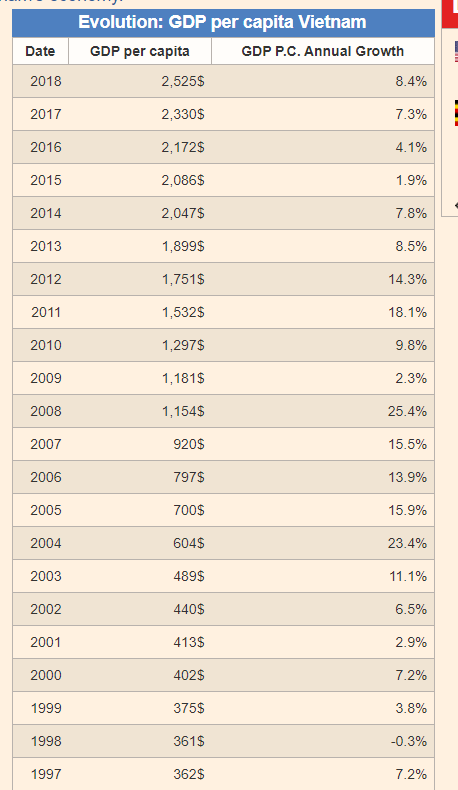

Đầu tiên ta lấy danh sách các quốc gia của website

In [14]:
all_url_gdp = 'https://countryeconomy.com/gdp?fbclid=IwAR0KijAVyc2jjKv7p7ESdugojBDsLSfLhQh7xIK-VC_T8jCD_r8I9i40gHE'
html_text = requests.get(all_url_gdp).text # Lấy nội dung html của trang chứa các kết quả tuyển dụng 
tree = BeautifulSoup(html_text, 'html.parser') # Parse html
title1_gdp = tree.find_all('table', {'id':'tbA'})

Hàm `link_countries_gdp` chứa tất cả link dẫn đến dữ liệu GDP bình quân đầu người của các quốc gia sản xuất gạo đã thu thập ở trên và lưu nó vào 1 list (theo đúng thứ tự quốc gia _ countries_official).
<br>
Khi chạy bug thì thấy tên đất nước trong contries_official có 2 quốc gia không sử dụng đúng tên nên tiến hành gắn quốc gia đó bằng tên 2 khác.

In [15]:
def link_countries_gdp(title1_gdp):
    countries = title1_gdp[-1].find_all('a')
    link_gdp_countries = title1_gdp[-1].find_all(href = True)
    relation_contries_link = []
    for country, link in zip(countries, link_gdp_countries):
        country = country.text
        relation_contries_link.append((country[: country.find(' [+]')],'https://countryeconomy.com'+link['href'] ))
    relation_contries_link = dict(relation_contries_link)
    list_link_gdp = []
    for country in countries_official:
        if country == 'Myanmar':
            country = 'Burma - Myanmar'
        if country == 'Lao PDR':
            country = 'Laos'
        if country in relation_contries_link.keys():
            list_link_gdp.append(relation_contries_link[country])
    return list_link_gdp
list_link_gdp = link_countries_gdp(title1_gdp)

In [16]:
list_link_gdp

['https://countryeconomy.com/gdp/india',
 'https://countryeconomy.com/gdp/indonesia',
 'https://countryeconomy.com/gdp/bangladesh',
 'https://countryeconomy.com/gdp/vietnam',
 'https://countryeconomy.com/gdp/burma',
 'https://countryeconomy.com/gdp/thailand',
 'https://countryeconomy.com/gdp/japan',
 'https://countryeconomy.com/gdp/cambodia',
 'https://countryeconomy.com/gdp/afghanistan',
 'https://countryeconomy.com/gdp/bhutan',
 'https://countryeconomy.com/gdp/iran',
 'https://countryeconomy.com/gdp/iraq',
 'https://countryeconomy.com/gdp/kazakhstan',
 'https://countryeconomy.com/gdp/laos',
 'https://countryeconomy.com/gdp/malaysia',
 'https://countryeconomy.com/gdp/nepal',
 'https://countryeconomy.com/gdp/pakistan',
 'https://countryeconomy.com/gdp/sri-lanka',
 'https://countryeconomy.com/gdp/turkmenistan',
 'https://countryeconomy.com/gdp/uzbekistan',
 'https://countryeconomy.com/gdp/argentina',
 'https://countryeconomy.com/gdp/brazil',
 'https://countryeconomy.com/gdp/colombia',
 

Dựa vào list link đã tìm được ở trên.
Hàm `merge_gdp_countries` ta vào mỗi link để parse lấy GDP bình quân đầu người của từng nước qua các năm (từ năm 1971-2014).
<br>
Sau đó merge lại thành 1 dictionary.

In [17]:
def merge_gdp_coutries(list_link_gdp):
    list_all_gdp = []
    for link in list_link_gdp:
        html_text = requests.get(link).text
        tree = BeautifulSoup(html_text, 'html.parser')
        table = tree.find_all('table', {'class': 'table tabledat table-striped table-condensed table-hover'})
        a = table[-1].find_all('td',{'class' : 'numero dol'})
        b = table[-1].find_all('td',{'class' : 'fecha'})
        i =0
        list_gdp = []
        while i < len(a):
            list_gdp.append(a[i]['data-value'])
            i += 2
        dictionary_gdp = []
        i = 0
        for year in b:
            dictionary_gdp.append((year.text, list_gdp[i]))
            i+= 1
        dictionary_gdp = dict(dictionary_gdp)
        list_years_continue = []
        for i in range(1971,2015):
            list_years_continue.append(i)
        value_gdp = []
        for year in dictionary_gdp.keys():
            if int(year) in list_years_continue:
                 value_gdp.append(dictionary_gdp[year])
        value_gdp = value_gdp[::-1]
        if len(dictionary_gdp.keys()) != 44:
            soluong = 44 - len(dictionary_gdp.keys()) + 4
            temp = []
            for i in range(0,soluong):
                temp.append(' ')
            value_gdp = temp + value_gdp
        list_all_gdp += value_gdp
    return list_all_gdp
all_gdp_value = merge_gdp_coutries(list_link_gdp)
list3_dictionary = {'GDP': all_gdp_value}

### 3. Lấy dữ liệu dân số từ API của world bank.

**Tổng quan về API world bank**
<br>
Dữ liệu được lấy bằng cách request thông qua API được cung cấp sẵn.
<br>
Ở đây ta lấy dữ liệu bằng dân số thông qua cú pháp:
<br>
http://api.worldbank.org/v2/country/ + "mã quốc gia" + "/indicator/SP.POP.TOTL" + "?format=json"


Do cú pháp để request có mã quốc gia nên việc đầu tiên ta cần làm là lấy mã của các quốc gia sản xuất gạo đã tìm được ở trên.
<br>
Vào trang https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm để lấy mã quốc gia và lưu nó vào 1 list.
<br>
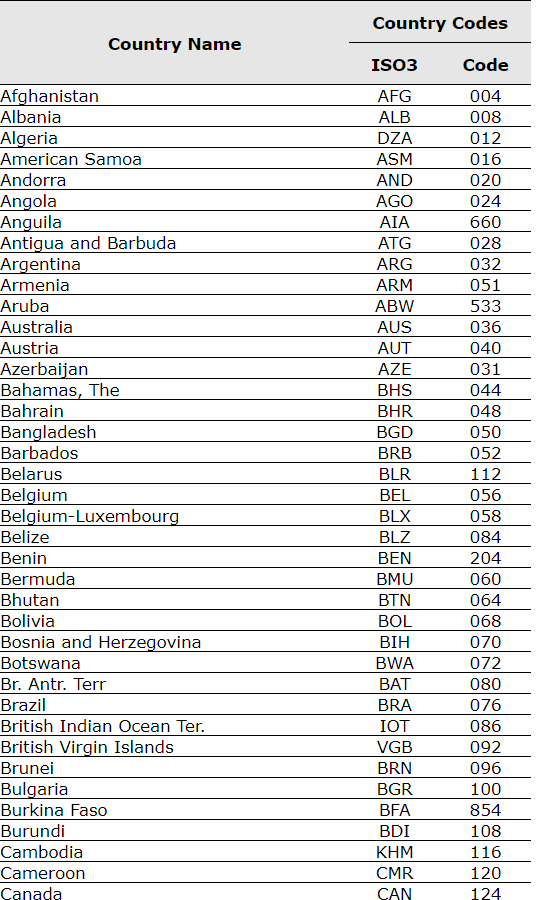

Hàm `get_abbreviations_countries` chứa tất cả link dẫn đến dữ liệu dân số của các quốc gia sản xuất gạo đã thu thập ở trên và lưu nó vào 1 list (theo đúng thứ tự quốc gia _ countries_official).
<br>
Khi chạy bug thì thấy tên đất nước trong contries_official có 1 quốc gia không sử dụng đúng tên nên tiến hành gắn quốc gia đó bằng tên 1 khác.

In [18]:
import urllib3
urllib3.disable_warnings()
def get_abbreviations_coutries(url_population):
    html_text = requests.get(url_population,verify = False).text # Lấy nội dung html của trang chứa các kết quả tuyển dụng 
    tree = BeautifulSoup(html_text, 'html.parser')
    codes = tree.find_all('td', {'class': 'td_WTBB'})
    i = 0
    countries = []
    code_list = []
    list_abbreviations_coutries = []
    while i < len(codes):
        countries.append(codes[i].text.strip())
        i += 1
        code_list.append(codes[i].text.strip())
        i += 2
        list_abbreviations_coutries.append((countries[-1],code_list[-1]))
    list_abbreviations_coutries = dict(list_abbreviations_coutries)
    list_abbreviations = []
    for country in countries_official:
        if country == 'Iran':
            country = 'Iran, Islamic Rep.'
        if country in list_abbreviations_coutries.keys():
            list_abbreviations.append('http://api.worldbank.org/v2/country/' + list_abbreviations_coutries[country] + '/indicator/SP.POP.TOTL?format=json')
    return list_abbreviations
url_population = 'https://wits.worldbank.org/wits/wits/witshelp/content/codes/country_codes.htm'
list_link_population = get_abbreviations_coutries(url_population)

In [19]:
list_link_population

['http://api.worldbank.org/v2/country/IND/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/IDN/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/BGD/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/VNM/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/MMR/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/THA/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/JPN/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/KHM/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/AFG/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/BTN/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/IRN/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/IRQ/indicator/SP.POP.TOTL?format=json',
 'http://api.worldbank.org/v2/country/KAZ/indicator/SP.POP.TOTL?

Dựa vào list link đã tìm được ở trên.
Hàm `merge_population_coutries` sẽ parse từng link lấy dân số của từng nước qua các năm (từ năm 1971-2014).
<br>
Sau đó merge lại thành 1 dictionary.

In [20]:
def merge_population_coutries(list_link_population):
    list_all_population = []
    for link in list_link_population:
        sources_ds = requests.get(link)
        sourcesJSON = sources_ds.json()
        dict_population=[]
        for i in sourcesJSON[1]:
            dict_population.append((i['date'], i['value']))
        dict_population = dict(dict_population)
        list_years_continue = []
        for i in range(1971,2015):
            list_years_continue.append(i)
        value_gdp = []
        for year in dict_population.keys():
            if int(year) in list_years_continue:
                 value_gdp.append(str(dict_population[year]))
        value_gdp = value_gdp[::-1]
        if len( dict_population.keys()) != 44:
            soluong = 44 - len(dict_population.keys()) + 4
            temp = []
            for i in range(0,soluong):
                temp.append(' ')
            value_gdp = temp + value_gdp
        list_all_population += value_gdp
    return list_all_population
all_population_value = merge_population_coutries(list_link_population)
list4_dictionary = {'Population': all_population_value}

**4. Tạo dataframe từ 4 dictionary đã thu thập:**

In [21]:
list_dictionary = {**list1_dictionary, **list2_dictionary, **list3_dictionary, **list4_dictionary}
data_df = pd.DataFrame.from_dict(list_dictionary)

data_df

,Arable land,Paddy yield,Milled production,Rice exports,Fertilizer usage,Rice area,Paddy Production,Rice imports,Total rice consumption,GDP,Population
0,"159,756.00",1.71,"43,089.53",15.85,16.63,"37,757.81","64,602.00",532.05,"41,577.75",119,567868018
1,"160,186.00",1.60,"39,264.92",14.99,17.28,"36,687.81","58,867.95",300.35,"41,593.65",123,581087256
2,"161,044.00",1.73,"44,073.36",17.78,17.63,"38,285.01","66,077.01",264.00,"42,310.84",144,594770134
3,"161,501.00",1.57,"39,786.55",41.43,15.93,"37,888.40","59,650.00",109.47,"41,890.58",163,608802600
4,"161,838.00",1.86,"48,925.78",18.29,21.59,"39,475.41","73,352.00",276.82,"47,148.31",158,623102897
...,...,...,...,...,...,...,...,...,...,...,...
1447,"4,145.00",5.30,210.25,133.47,82.09,59.48,315.21,0.90,44.78,4347,6248020
1448,"4,305.00",5.19,272.30,203.89,97.64,78.61,408.25,1.14,52.41,5298,6333976
1449,"4,415.00",4.95,264.13,262.06,83.30,80.00,396.00,0.99,56.60,5151,6421512
1450,"4,500.00",6.30,411.80,366.28,96.92,98.00,617.40,1.12,57.86,5883,6510276


**Đưa ra câu hỏi cần trả lời:**

- Lượng gạo tiêu thụ được tính như thế nào thông qua các thuộc tính còn lại.

**Ý nghĩa của việc trả lời câu hỏi trên:**

- Trong bối cảnh biến đổi khí hậu, diện tích trồng trọt bị thu hẹp đáng kể do các nguyên nhân như là: xâm nhập mặn, sạt lở đất, đất đai bạc màu... Dân số biến động liên tục do dịch bệnh, người di cư từ khu vực này sang khu vực khác. Cộng thêm việc các hợp đồng xuất, nhập khẩu gạo thường được ký kết trước vài năm.
- Các lý do này dẫn đến ý tưởng cần dự đoán trước lượng gạo tiêu thụ của một nước để có thể bảo đảm an ninh lương thực quốc gia và tối ưu hóa cán cân xuất nhập khẩu.


**Ý nghĩa các thuộc tính:**
- **Arable land**: Diện tích đất có thể canh tác được, đơn vị nghìn ha.
<br>
- **Paddy yield**: Năng suất, đơn vị tấn/ha.
<br>
- **Miled Production**: Sản lượng gạo, đơn vị nghìn tấn.
<br>
- **Rice exports** : Lượng gạo xuất khẩu, đơn vị nghìn tấn.
<br>
- **Fertilizer usage**: Lượng phân bón sử dụng, đơn vị nghìn tấn.
<br>
- **Rice area**: Diện tích trồng lúa, đơn vị nghìn ha.
<br>
- **Paddy production**: Sản lượng lúa, đơn vị nghìn tấn.
<br>
- **Rice imports**: Lượng gạo nhập khẩu, đơn vị nghìn tấn.
<br>
- **Total rice consumption**: Tổng lượng gạo tiêu thụ, đơn vị nghìn tấn.
<br>
- **GDP**: Tổng thu nhập bình quân đầu người, đơn vị $.
<br>
- **Population**: Tổng dân số, đơn vị người.

**Ép về đúng kiểu dữ liệu**

Ta sẽ ép về dữ liệu số đối với các cột có kiểu là số bởi vì khi parse các trang thì dữ liệu ở dạng chuỗi.

In [22]:
list_columns = data_df.columns
for column in list_columns:
    data_df[column] = data_df[column].str.replace(',','')
    data_df[column] = pd.to_numeric(data_df[column], errors ='coerce')

#II. Khám phá dữ liệu và tiền xử lý

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns # seaborn là thư viện được xây trên matplotlib, giúp việc visualization đỡ khổ hơn
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.neural_network import MLPRegressor
from sklearn import set_config
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer
from sklearn.preprocessing import FunctionTransformer
from sklearn.metrics import r2_score
#set_config(display='diagram') # Để trực quan hóa pipeline

**Dữ liệu có bao nhiêu dòng và bao nhiêu cột?**

In [24]:
data_df.shape

(1452, 11)

**Mỗi dòng có ý nghĩa gì? Có vấn đề các dòng có ý nghĩa khác nhau không?**

**Dữ liệu có các dòng bị lặp không?**

In [25]:
data_df.index.duplicated().sum()

0

## Khám phá dữ liệu (để biết cách tách các tập)
Để biết cách tách các tập thì ta cần khám phá thêm cột output một ít:
- Cột này hiện có kiểu dữ liệu là gì? Trong bài toán hồi qui thì cột output bắt buộc phải có dạng số; nếu hiện chưa có dạng số (ví dụ, số nhưng được lưu dưới dạng chuỗi) thì ta cần chuyển sang dạng số rồi mới tách các tập.
- Cột này có giá trị thiếu không? Nếu có giá trị thiếu thì ta sẽ bỏ các dòng mà output có giá trị thiếu rồi mới tách các tập (loại học mà học từ dữ liệu trong đó output có giá trị thiếu được gọi là semi-supervised learning; trong phạm vi môn học, ta không đụng tới loại học này).

**Cột output hiện có kiểu dữ liệu gì?**

In [26]:
data_df['Total rice consumption'].dtype

dtype('float64')

**Cột output có giá trị thiếu không?**

In [27]:
# Cột output có giá trị thiếu không?
data_df['Total rice consumption'].isna().sum()

173

**Tiến hành xóa các dòng output thiếu dữ liệu**

In [28]:
missing_output = data_df['Total rice consumption'].isna()
delete = missing_output
delete = ~delete
data_df = data_df[delete]

In [29]:
data_df.shape

(1279, 11)

## Tiền xử lý (tách tập)

Input của bài toán sẽ bao gồm một số cột trong dữ liệu. Output chính là cột `total_rice_consumption`. 

In [30]:
# Tách X và y
y_sr = data_df["Total rice consumption"] # sr là viết tắt của series
X_df = data_df.drop("Total rice consumption", axis=1)

Tách theo tỉ lệ: 60% : 20% : 20% lần lượt cho bộ train, bộ validation, bộ test (dựa vào phương pháp phân phối dữ liệu cổ điển).

In [31]:
# Tách (tập train, validation) và tập test theo tỉ lệ 80%:20%
new_X_df, test_X_df, new_y_sr, test_y_sr = train_test_split(X_df, y_sr, test_size=0.2,random_state=1)

Tách tập train và tập validation

In [32]:
# Tách tập huấn luyện và tập validation theo tỉ lệ 75%:25%
train_X_df, val_X_df, train_y_sr, val_y_sr = train_test_split(new_X_df, new_y_sr, test_size=0.25,random_state=1)

**Dữ liệu có bao nhiêu dòng và bao nhiêu cột?**

In [33]:
test_X_df.shape

(256, 10)

In [34]:
train_X_df.shape

(767, 10)

In [35]:
val_X_df.shape

(256, 10)

## Khám phá dữ liệu (tập huấn luyện)

Mỗi cột hiện đang có kiểu dữ liệu gì? Có cột nào có kiểu dữ liệu chưa phù hợp để có thể xử lý tiếp không?

In [36]:
train_X_df.dtypes

Arable land          float64
Paddy yield          float64
Milled production    float64
Rice exports         float64
Fertilizer usage     float64
Rice area            float64
Paddy Production     float64
Rice imports         float64
GDP                  float64
Population             int64
dtype: object

**Với mỗi cột input có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?**

In [37]:
df = train_X_df.select_dtypes(exclude = 'object')
def missing_ratio(df):
    return (df.isna().mean() * 100).round(1)
def lower_quartile(df):
    return df.quantile(0.25).round(1)
def median(df):
    return df.quantile(0.5).round(1)
def upper_quartile(df):
    return df.quantile(0.75).round(1)
df.agg([missing_ratio, 'min', lower_quartile, median, upper_quartile, 'max'])

,Arable land,Paddy yield,Milled production,Rice exports,Fertilizer usage,Rice area,Paddy Production,Rice imports,GDP,Population
missing_ratio,0.0,0.00,0.00,29.7,1.20,0.0,0.0,11.00,0.0,0.000000e+00
min,200.0,0.68,9.14,0.0,0.00,14.7,13.7,0.00,26.0,1.563093e+06
lower_quartile,1715.5,2.30,215.00,1.0,17.50,112.8,322.3,2.20,456.5,9.739812e+06
median,3700.0,3.00,1070.60,16.9,61.00,471.0,1605.2,34.70,1409.0,2.078307e+07
upper_quartile,14020.5,4.10,5788.80,258.4,151.00,2413.9,9116.1,237.00,3268.5,6.111428e+07
max,163618.0,8.38,106186.40,11300.1,2241.37,44900.0,159200.0,4671.22,44674.0,1.280846e+09


**Với mỗi cột input không có kiểu dữ liệu dạng số, các giá trị được phân bố như thế nào?**

In [38]:
df = train_X_df.select_dtypes(include = 'object')
len(df.columns)

0

- Ta nhận thấy dữ liệu trong bài không có dữ liệu dạng số.

## Tiền xử lý (tập huấn luyện)

- Loại bỏ các thuộc tính không có ích cho việc huấn luyện mô hình như `paddy yield` bởi vì đây là thuộc tính suy diễn, có thể suy ra từ 2 thuộc tính Paddy Production và Rice area.

In [39]:
def ColAdderDropper(X_df):
    temp_X = X_df.copy(deep=True) #tao dataframe moi tu X_df
    temp_X.drop(['Paddy yield'], inplace=True, axis=1) #xoa thuoc tinh Paddy yield
    return temp_X

- Chỉ cần "transform" tập dữ liệu mà không cần tính toán giá trị gì từ tập huấn luyện thì dùng FunctionTransformer.

In [40]:
fewer_cols_train_X_df = FunctionTransformer(ColAdderDropper).fit_transform(train_X_df)
fewer_cols_train_X_df.shape

(767, 9)

**Với các cột dạng số và không có thứ tự:**
- Ta sẽ điền giá trị thiếu bằng phương pháp KNN bởi vì khi điền mean và mode sẽ làm các giá trị thiếu khi điền vào bị chênh lệch nhiều so với thực tế.

In [41]:
# YOUR CODE HERE
attribute_cols = fewer_cols_train_X_df.columns
imputer = KNNImputer(metric='nan_euclidean') # sử dụng thuật toán knn với n_neighbors = 3 để điền giá trị thiếu
x_pipeline = make_column_transformer(
    (make_pipeline(imputer), attribute_cols),
)
preprocess_pipeline = make_pipeline(FunctionTransformer(ColAdderDropper),
                                    x_pipeline, StandardScaler())
preprocessed_train_X = preprocess_pipeline.fit_transform(train_X_df)

In [42]:
preprocess_pipeline

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function ColAdderDropper at 0x7fd2d22bb488>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[...
                                                                              copy=True,
                                                                              metric='nan_euclidean',
                                                                              missing_values=nan,
                                                                 

Khi đã có `preprocess_pipeline` đã được tính từ tập huấn luyện, ta có thể dễ dàng dùng phương thức `transform` để tiền xử lý cho các véc-tơ input mới trong tập validation và tập kiểm tra.

In [43]:
preprocessed_val_X = preprocess_pipeline.transform(val_X_df)

#III. Tiền xử lý + mô hình hóa

#### Thử nghiệm 1: Mô hình MLP

- Chọn dùng activation=relu do đây là hàm được sử dụng phổ biến và bài toán nhóm đang sử dụng là bài toán hồi quy.
 - Không chọn activation = tanh bởi vì làm tròn dữ liệu dưới dạng (0,1) nên việc sử dụng sẽ gây ra hiện tượng max-iter rất khó để hội tụ.

Vì vậy, chỉ một neuron nhất định được kích hoạt nên hàm Relu hiệu quả hơn nhiều về mặt tính toán khi so sánh với hàm logistic và tanh.
- Chọn solver = lbfgs vì dữ liệu trên các tập dữ liệu tương đối nhỏ ( 767 dòng dữ liệu).
- Thử nghiệm nhiều giá trị của siêu tham số alpha và n_neighbors để tìm được độ lỗi trên tập validation tối ưu.


In [44]:
# Tạo full pipeline
nume_cols = train_X_df.columns
# YOUR CODE HERE
neural_net_model = MLPRegressor(hidden_layer_sizes=(20,), activation='relu',
                                 solver='lbfgs', max_iter=5000, random_state=0)

full_pipeline = make_pipeline(FunctionTransformer(ColAdderDropper), x_pipeline,
                              StandardScaler(), neural_net_model)
# Thử nghiệm với các giá trị khác nhau của các siêu tham số
# và chọn ra các giá trị tốt nhất
train_errs = []
val_errs = []
alphas = [0.1, 1, 10, 100, 1000, 3000, 10000,100000]
n_neighbors =  [2,3,5,8,10,20,30,50]
best_val_err = float('inf'); best_alpha = None ; best_neighbor = None
temp = []
for alpha in alphas:
    for neighbor in n_neighbors:
        full_pipeline.set_params(mlpregressor__alpha = alpha,columntransformer__pipeline__knnimputer__n_neighbors = neighbor)
        full_pipeline.fit(train_X_df,train_y_sr)
        train_errs.append((1 - full_pipeline.score(train_X_df,train_y_sr))*100)
        value_error = (1- full_pipeline.score(val_X_df,val_y_sr))*100
        val_errs.append(value_error)
        temp.append([value_error, alpha, neighbor])
best_val_err = min(val_errs)
index = val_errs.index(min(val_errs))
best_alpha = temp[index][1]
best_neighbor = temp[index][2]
'Finish!'

'Finish!'

In [45]:
print(best_val_err)
print(best_alpha)
print(best_neighbor)

0.07927147571231696
1000
2


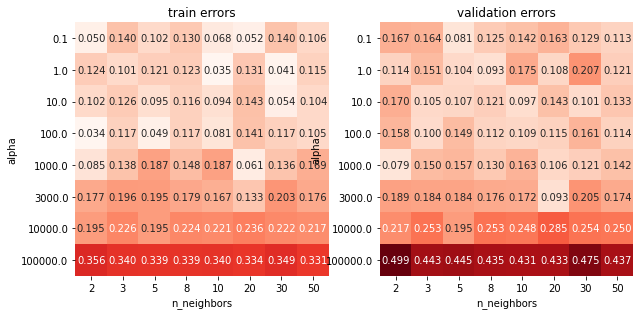

In [46]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(alphas), -1),
                             index=alphas, columns= n_neighbors)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(alphas), -1), 
                           index=alphas, columns= n_neighbors)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train errors'); plt.xlabel('n_neighbors'); plt.ylabel('alpha')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation errors'); plt.xlabel('n_neighbors'); plt.ylabel('alpha');

**Nhận xét**
<br>
- Ta thấy độ lỗi trên tập train cũng xấp xỉ với độ lỗi trên tập validation điều đó chứng tỏ mô hình fit khá tốt trên cả 2 tập dữ liệu.
- Khi alpha tăng dần, tức sự ảnh hưởng của regularization tăng lên thì độ lỗi trên tập train cũng tăng theo do mô hình bị kìm hãm việc học khi có alpha lớn.
- Khi tăng hệ số alpha lên quá lớn thì gây ra hiện tượng underfit.
<br>
- Trên cả 2 tập train và valid, độ lỗi đều đạt min khi tham số n_neighbors = 2 -> đây là tham số tối ưu.

Huấn luyện lại full_pipeline trên X_df và y_sr (tập huấn luyện + tập validation) với best_alpha và best_num_neighbor tìm được ở trên để ra được mô hình cụ thể cuối cùng.



In [47]:
full_pipeline.set_params(mlpregressor__alpha= best_alpha, columntransformer__pipeline__knnimputer__n_neighbors = best_neighbor)
full_pipeline.fit(new_X_df, new_y_sr)

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function ColAdderDropper at 0x7fd2d22bb488>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[...
                              beta_1=0.9, beta_2=0.999, early_stopping=False,
                              epsilon=1e-08, hidden_layer_sizes=(20,),
                              learning_rate='constant',
                              learning_rate_init=0.001, max_fun=15000,
                              max_iter=5000, momentum=0.9, n_iter_no_change=10

##### Đánh giá mô hình tìm được

In [48]:
(1 - full_pipeline.score(new_X_df,new_y_sr)) * 100 # do loi tren toan bo tap huan luyen va tap validation

0.08494704724988367

In [49]:
(1 - r2_score(test_y_sr, full_pipeline.predict(test_X_df))) * 100 # do loi tren tap test

0.2548413750649625

**Trực quan hóa mô hình tìm được**

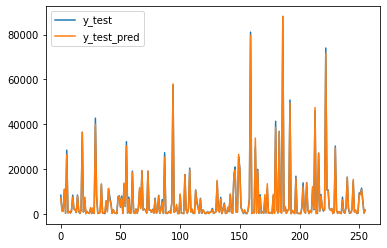

In [50]:
#Truc quan hoa mo hinh 
plt.plot(test_y_sr.reset_index(drop=True))
plt.plot(full_pipeline.predict(test_X_df))
plt.legend(['y_test','y_test_pred'])

#### Thử nghiệm 2: Mô hình LinearRegression

In [51]:
from sklearn.linear_model import LinearRegression

Thử nghiệm nhiều giá trị của siêu tham số n_neighbors để tìm được độ lỗi trên tập validation tối ưu.

In [52]:
from sklearn.linear_model import LinearRegression
# Tạo full pipeline
nume_cols = train_X_df.columns
# YOUR CODE HERE
model3 = LinearRegression()
full_pipeline1 = make_pipeline(FunctionTransformer(ColAdderDropper), x_pipeline,
                              StandardScaler(), model3)
train_errs = []
val_errs = []
temp=[]
n_neighbors =  [2,3,5,8,10,20,30,50]
best_val_err = float('inf'); best_alpha = None ; best_neighbor1 = None
for neighbor in n_neighbors:
    full_pipeline1.set_params(columntransformer__pipeline__knnimputer__n_neighbors = neighbor)
    full_pipeline1.fit(train_X_df,train_y_sr)
    train_errs.append((1 - full_pipeline1.score(train_X_df,train_y_sr))*100)
    value_error = (1- full_pipeline1.score(val_X_df,val_y_sr))*100
    val_errs.append(value_error)
    temp.append([value_error, neighbor])
best_val_err = min(val_errs)
index = val_errs.index(min(val_errs))
best_neighbor1 = temp[index][1]
'Finish!'

'Finish!'

In [53]:
print(best_val_err)
print(best_neighbor1)

0.41842221243634237
30


Text(483.1943181818181, 0.5, 'n_neighbors')

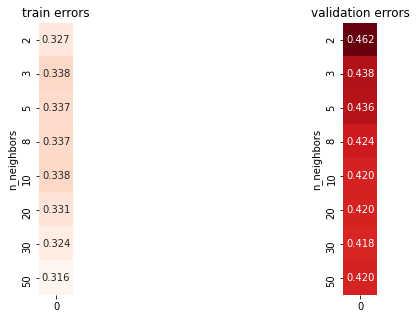

In [54]:
# Trực quan hóa kết quả
train_errs_df = pd.DataFrame(data=np.array(train_errs).reshape(len(n_neighbors), -1),
                             index= n_neighbors)
val_errs_df = pd.DataFrame(data=np.array(val_errs).reshape(len(n_neighbors), -1), 
                           index= n_neighbors)
min_err = min(min(train_errs), min(val_errs))
max_err = max(max(train_errs), max(val_errs))
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
sns.heatmap(train_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('train errors'); plt.ylabel('n_neighbors')
plt.subplot(1, 2, 2)
sns.heatmap(val_errs_df, vmin=min_err, vmax=max_err, square=True, annot=True, 
            cbar=False, fmt='.3f', cmap='Reds')
plt.title('validation errors'); plt.ylabel('n_neighbors')

Huấn luyện lại full_pipeline trên X_df và y_sr (tập huấn luyện + tập validation) với best_neighbor tìm được ở trên để ra được mô hình cụ thể cuối cùng.


In [55]:
full_pipeline1.set_params(columntransformer__pipeline__knnimputer__n_neighbors = best_neighbor1)
full_pipeline1.fit(new_X_df, new_y_sr)

Pipeline(memory=None,
         steps=[('functiontransformer',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function ColAdderDropper at 0x7fd2d22bb488>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, validate=False)),
                ('columntransformer',
                 ColumnTransformer(n_jobs=None, remainder='drop',
                                   sparse_threshold=0.3,
                                   transformer_weights=None,
                                   transformers=[...
                                                  Index(['Arable land', 'Milled production', 'Rice exports', 'Fertilizer usage',
       'Rice area', 'Paddy Production', 'Rice imports', 'GDP', 'Population'],
      dtype='object'))],
                                   verbose=False)),
                ('standardscaler',
                 StandardScaler(cop

##### Đánh giá mô hình tìm được

In [56]:
(1 - full_pipeline1.score(new_X_df,new_y_sr)) * 100 # do loi tren toan bo tap huan luyen va tap validation

0.3510137520312595

In [57]:
(1 - r2_score(test_y_sr, full_pipeline1.predict(test_X_df))) * 100 # do loi tren tap test

0.4148420887598592

##**Mô hình tìm được tốt nhất**


Dự vào kết quả độ lỗi trên tập validation và tập test ta thấy rằng mô hình MLP Regressor hoạt động tốt hơn mô hình Linear Regression với các siêu tham số như sau:

MLPRegressor(hidden_layer_sizes=(20,), activation='relu',
                                 solver='lbfgs', max_iter=5000, alpha = 1000, random_state=0) và chọn siêu tham số n_neighbors = 2.

### Giải thích vì sao mô hình tìm được độ lỗi trên tập (train và validation) và tập test đều nhỏ hơn 1%

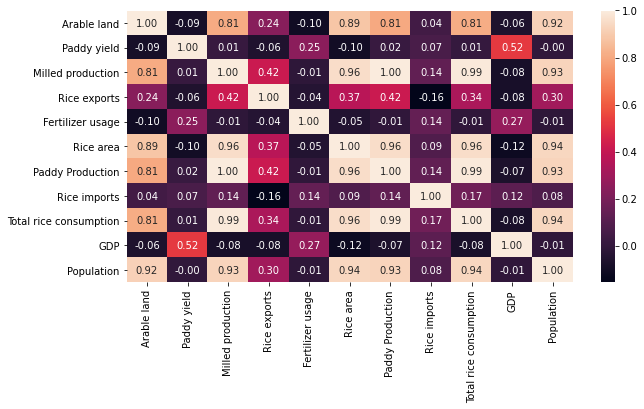

In [58]:
df_small = data_df.iloc[:,:11]
correlation_mat = df_small.corr()
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_mat,fmt='.2f', annot = True)

**Công thức tính độ tương quan giữa 2 thuộc tính:**
<br>
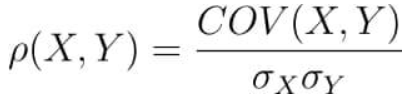

Nếu p(X,y) có giá trị dương cho thấy mối quan hệ đồng biến hoặc tương quan dương (đồng biến tuyệt đối khi giá trị bằng 1).
<br>
Nếu p(X,y) có giá trị âm cho thấy hai biến có mối quan hệ nghịch biến hoặc tương quan âm (nghịch biến tuyệt đối khi giá trị bằng -1).
<br>
Nếu p(X,y) có giá trị bằng 0 cho hai biến độc lập với nhau.

**Nhận xét:**
- Dựa vào ma trận tương quan, hầu hết thuộc tính có độ tương quan với thuộc tính output(`total rice consumption`).
- Bởi vì mô hình được trang bị nhiều thuộc tính liên quan đến lượng gạo tiêu thụ nên dữ liệu chặt chẽ. Ngoài ra, mô hình được trang bị phù hợp có các siêu tham số nắm bắt các mối quan hệ phức tạp giữa các biến đã biết và biến mục tiêu chặt chẽ, dữ liệu ít nhiễu.